In [1]:
from tmm_ml_models import ReverseTMMModel, ForwardTMMModel
import pandas as pd
import matplotlib.pyplot as plt



curve = pd.read_csv("RecipeCurve.csv", names=["Wavelength", "Reflectance"], index_col="Wavelength")
curve = curve.transpose()
curve.index = [1]

2023-06-21 12:43:45.671669: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 12:43:45.738647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 12:43:45.739630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 12:43:46.593537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
reverse_model = ReverseTMMModel(serialised_model_path="reverse_model_v1_with_metrics")
f_model = ForwardTMMModel(serialised_model_path="forward_model.mdlsav")

In [3]:
materials = reverse_model.predict(curve)
materials

1/1 [==============================] - 0s 154ms/step


,d1,d2,d3,d4,d5,d6,First Layer,Second Layer
1,10.65939,61.539623,34.860306,32.441422,23.88052,32.633213,Mo,MoO3


1/1 [==============================] - 0s 193ms/step


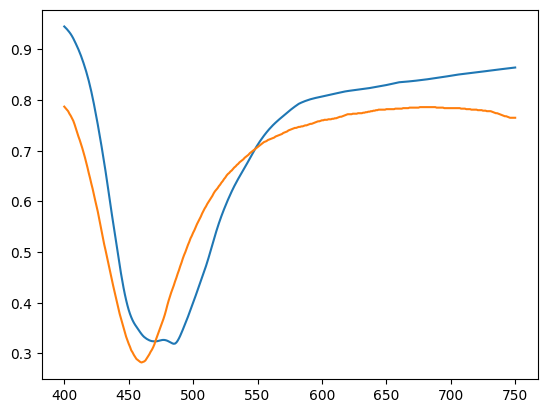

In [4]:
predicted_curve = f_model.predict(materials)

fig,ax = plt.subplots()

plt.plot(predicted_curve.transpose())
plt.plot(curve.transpose())

In [5]:
materials[["First Layer", "Second Layer"]].values[0,1]

'MoO3'

In [6]:
from transfer_matrix_method.refractive_index import MaterialRefractiveIndex, YAMLRefractiveIndex
from transfer_matrix_method.reflectance import reflectance, Layer
import numpy as np

Mo = MaterialRefractiveIndex("Mo")
with open("transfer_matrix_method/data/yaml_formatted/MoO3.yml") as f:
    MoO3 = YAMLRefractiveIndex(f)

ris = {
    "Mo": Mo,
    "MoO3": MoO3
}

layers = [Layer(t*1e-9, ris[materials[["First Layer", "Second Layer"]].values[0,i%2]]) for i, t in enumerate(materials[["d1", "d2", "d3", "d4", "d5", "d6"]].values[0])]

In [7]:
layers

[Layer(thickness=1.0659390449523927e-08, refractive_index=<transfer_matrix_method.refractive_index.MaterialRefractiveIndex object at 0x7fe78830a1d0>),
 Layer(thickness=6.153962326049805e-08, refractive_index=<transfer_matrix_method.refractive_index.YAMLRefractiveIndex object at 0x7fe78174cca0>),
 Layer(thickness=3.486030578613282e-08, refractive_index=<transfer_matrix_method.refractive_index.MaterialRefractiveIndex object at 0x7fe78830a1d0>),
 Layer(thickness=3.2441421508789065e-08, refractive_index=<transfer_matrix_method.refractive_index.YAMLRefractiveIndex object at 0x7fe78174cca0>),
 Layer(thickness=2.388051986694336e-08, refractive_index=<transfer_matrix_method.refractive_index.MaterialRefractiveIndex object at 0x7fe78830a1d0>),
 Layer(thickness=3.263321304321289e-08, refractive_index=<transfer_matrix_method.refractive_index.YAMLRefractiveIndex object at 0x7fe78174cca0>)]

In [14]:
x = np.arange(400,751)
y = [reflectance(layers, lam*1e-9, substrate=Layer(100000e-9, MaterialRefractiveIndex("SiO2")))["reflectance"] for lam in x]
# y = [reflectance([Layer(250*1e-9, Mo)], lam*1e-9)["reflectance"] for lam in x]

plt.plot(x,y)
# plt.ylim((0,1))

plt.ylabel("Reflectance")
plt.xlabel("Wavelength ($nm$)")

plt.grid()

KeyboardInterrupt: 

In [28]:
training_data = pd.read_csv("R.csv")
combo = training_data[(training_data["First Layer"] == "Mo") & (training_data["Second Layer"] == "MoO3")]


In [30]:
t = ["d1", "d2", "d3", "d4", "d5", "d6"]

thicknesses = materials[t]
combo["score"] = (combo[t] - materials[t].squeeze()).sum(axis=1).apply(abs)
combo[combo["score"] == combo["score"].min()]

/tmp/ipykernel_9455/2782263965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo["score"] = (combo[t] - materials[t].squeeze()).sum(axis=1).apply(abs)


,d1,d2,d3,d4,d5,d6,First Layer,Second Layer,W400,W401,...,W742,W743,W744,W745,W746,W747,W748,W749,W750,score
3294,40,30,40,40,30,20,Mo,MoO3,0.937334,0.937739,...,0.949958,0.949954,0.949949,0.949945,0.949942,0.949938,0.949935,0.949932,0.949929,3.985526
6009,40,30,10,50,10,60,Mo,MoO3,0.934502,0.934315,...,0.949206,0.949204,0.949202,0.949201,0.949200,0.949200,0.949199,0.949199,0.949199,3.985526
14691,30,60,30,40,10,30,Mo,MoO3,0.921740,0.920718,...,0.941403,0.941414,0.941426,0.941437,0.941449,0.941460,0.941472,0.941484,0.941497,3.985526
19623,60,20,60,40,10,10,Mo,MoO3,0.947926,0.948057,...,0.952135,0.952128,0.952121,0.952114,0.952108,0.952102,0.952096,0.952091,0.952086,3.985526
26517,30,10,30,40,50,40,Mo,MoO3,0.939404,0.939731,...,0.949456,0.949451,0.949446,0.949441,0.949437,0.949433,0.949429,0.949426,0.949422,3.985526
29337,20,40,10,50,30,50,Mo,MoO3,0.874697,0.875887,...,0.926129,0.926162,0.926195,0.926228,0.926262,0.926295,0.926329,0.926363,0.926397,3.985526


In [31]:
materials[t]

,d1,d2,d3,d4,d5,d6
1,10.65939,61.539623,34.860306,32.441422,23.88052,32.633213


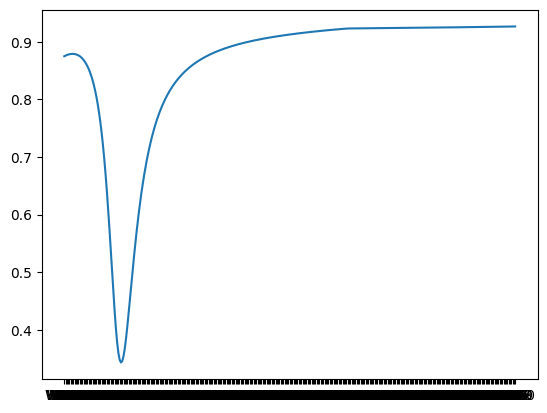

In [32]:
plt.plot(combo.loc[29337][[c for c in combo.columns if c not in [*t, "First Layer", "Second Layer", "score"]]])